
        Karol Widuch    - widuch@student.agh.edu.pl

        Konrad Kalita   - konradkalita@student.agh.edu.pl
        

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
from collections import namedtuple
from numpy import save

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

warnings.filterwarnings("ignore")

### Zadanie na dst
W oparciu o sieć głęboką z notatnika “ Speech Recognition.ipynb” należy sprawdzić jak "skuteczność" klasyfikacji wybranych pięciu słów z bazy nagrań w języku angielskim zależy od liczebności zbioru treningowego.

Raport z zadania powinien prezentować (w formie graficznej/tabelarycznej) zarówno elementy macierzy pomyłek jak i wartości różnych parametrów używanych do mierzenia skuteczności klasyfikacji w przypadku klasyfikacji wieloklasowej.

In [2]:
data_path = './data/'
models_path = './models/'
train_audio_path = './input/train/audio/'
test_audio_path = './input/test/audio/'
sample_audio_path = f"{train_audio_path}yes/0a7c2a8d_nohash_0.wav"

In [3]:
labels = os.listdir(train_audio_path)[:5]

print(labels)

['bed', 'bird', 'cat', 'dog', 'down']


### Przygotowanie danych

In [4]:
all_waves = []
all_labels = []

for label in labels:
    waves = [f for f in os.listdir(f"{train_audio_path}/{label}") if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(f"{train_audio_path}/{label}/{wav}", sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)


le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = np.array(le.classes_)

y = np_utils.to_categorical(y, num_classes=len(labels))
all_waves = np.array(all_waves).reshape(-1,8000,1)

x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_waves), np.array(y), stratify=y, test_size = 0.2, random_state=777, shuffle=True)

print(f"Training set shape: \t\t{x_tr.shape}")
print(f"Validation set shape: \t\t{x_val.shape}")

training_datasets = {}

for i in range(1000, len(x_tr), 200):
    training_datasets[int((i-1000)/200)] = (x_tr[:i], y_tr[:i])
    
print(f"Training_datasets number: \t{len(training_datasets)}")
print(f"Count of smallest set: \t\t{min(training_datasets)}")
print(f"Count of biggest set: \t\t{max(training_datasets)}")

Training set shape: 		(6575, 8000, 1)
Validation set shape: 		(1644, 8000, 1)
Training_datasets number: 	28
Count of smallest set: 		0
Count of biggest set: 		27


### Budowa modelu

In [5]:
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

### Szkolenie modeli dla różnych liczeności zbiorów testowych

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=0, patience=10, min_delta=0.0001)
scores = {}

print(f"Num of datasets:\t{len(training_datasets)}")

for i in training_datasets:
    filename = f'model_{training_datasets[i][0].shape[0]}.hdf5'
    mc = ModelCheckpoint(models_path+filename, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    x_tr_i, y_tr_i = training_datasets[i]
    history = model.fit(x_tr_i, y_tr_i, epochs=3, callbacks=[es,mc], batch_size=32, validation_data=(x_val, y_val), verbose=False)

    y_val_class = classes[np.argmax(y_val, axis=1)]
    y_pred_class = classes[np.argmax(model.predict(x_val), axis=1)]

    conf_matrix = confusion_matrix(y_pred_class, y_val_class)
    report = classification_report(y_pred_class, y_val_class)

    score = min(history.history['val_loss'])
    scores[i] = {
        'count': int(i*200 + 1000),
        'history': history.history, 
        'confusion_matrix': conf_matrix, 
        'classification_report': report}

    print(f"Dataset {i+1}:\t\tNum: {scores[i]['count']}\tscore: {score}")

Num of datasets:	28
Dataset 1:		Num: 1000	score: 1.5848100185394287
Dataset 2:		Num: 1200	score: 1.465079426765442
Dataset 3:		Num: 1400	score: 1.1800403594970703
Dataset 4:		Num: 1600	score: 1.1206042766571045
Dataset 5:		Num: 1800	score: 0.9980030059814453
Dataset 6:		Num: 2000	score: 0.8577015995979309
Dataset 7:		Num: 2200	score: 0.8086313009262085
Dataset 8:		Num: 2400	score: 0.7120639681816101
Dataset 9:		Num: 2600	score: 0.6067929863929749
Dataset 10:		Num: 2800	score: 0.57602858543396
Dataset 11:		Num: 3000	score: 0.5393199920654297
Dataset 12:		Num: 3200	score: 0.5891498327255249
Dataset 13:		Num: 3400	score: 0.4966337978839874
Dataset 14:		Num: 3600	score: 0.46360018849372864
Dataset 15:		Num: 3800	score: 0.4690728485584259
Dataset 16:		Num: 4000	score: 0.46144983172416687
Dataset 17:		Num: 4200	score: 0.4521366059780121
Dataset 18:		Num: 4400	score: 0.45941805839538574
Dataset 19:		Num: 4600	score: 0.4747527837753296
Dataset 20:		Num: 4800	score: 0.4222621023654938
Dataset 2

### Wykres zależności ilości danych od skuteczności

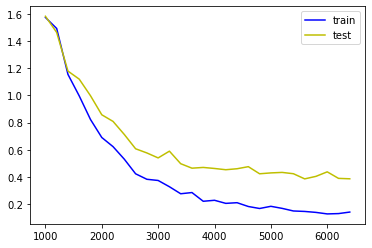

In [7]:
num_of_samples = [scores[key]['count'] for key in scores]
losses = [min(scores[key]['history']['loss']) for key in scores]
val_losses = [min(scores[key]['history']['val_loss']) for key in scores]

plt.plot(num_of_samples, losses, 'b', label='train')
plt.plot(num_of_samples, val_losses, 'y', label='test')
plt.legend()
plt.show()

### Raport oraz macierz pomyłek

In [8]:
index = np.argmin(np.array(val_losses))
best_report = scores[index]['classification_report']
best_matrix = scores[index]['confusion_matrix']

print(best_report)
print(best_matrix)

              precision    recall  f1-score   support

         bed       0.88      0.76      0.82       343
        bird       0.92      0.90      0.91       313
         cat       0.87      0.82      0.85       319
         dog       0.87      0.87      0.87       309
        down       0.78      0.93      0.85       360

    accuracy                           0.86      1644
   macro avg       0.86      0.86      0.86      1644
weighted avg       0.86      0.86      0.86      1644

[[261  17  30  11  24]
 [ 16 281   1   7   8]
 [ 16   2 263   8  30]
 [  0   2   4 270  33]
 [  4   2   5  13 336]]


### Wnioski

Jak widać na wykresie powyżejwraz ze wzrostem liczebności próbek znacząco wzrasta skuteczność predykcji naszego modelu. Od pewnego momentu natomiast można zauważyć pewne wahania i nieznaczną poprawę jakości modelu. Zgodnie z wynikami widzimy jednak, że najlepszy rezultat model uzyskał dla 5600 próbek.
Analizując macierz pomyłek i raport klasyfikacji widzimy, że nasze predykcje są poprawne i nie ma znaczących błędów w konstrukcji modelu.